<a href="https://colab.research.google.com/github/clementine-lev/ML/blob/main/ml__7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Business Problem

The goal of this project is to predict bicycle traffic in the Lyon metropolitan area using machine-learning models.
Because weather data could not be merged (daily values vs. annual aggregated bicycle counts), the prediction relies solely on infrastructure and spatial features, including:

- maximum hourly flow

- number of lanes

- sensor type and measurement post type

- peak flow hour

- reference year

- geographic location (longitude, latitude)

- commune of the sensor and its population (pop2022)

These variables capture how infrastructure capacity, sensor characteristics, and local demographics influence bicycle usage.

This model supports:

- urban planning (where to build or improve bike lanes),

- infrastructure investment decisions,

- understanding spatial patterns of cycling activity,

predicting baseline mobility flows across communes.

The target variable is the average weekday bicycle count, representing typical cycling activity on working days.

In [ ]:

# Standard Libraries

import pandas as pd
import numpy as np


# Visualisation

import matplotlib.pyplot as plt
import seaborn as sns


# Geospatial Analysis

import geopandas as gpd
from shapely.geometry import Point


# Machine Learning - Preprocessing

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


# Machine Learning - Models

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


# Machine Learning - Metrics

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)


# Feature Selection

from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Statistics Tools

import scipy.stats as stats



#1) Geospatial Preprocessing & Feature Engineering

In this section, we clean the geographical coordinates and transform the raw sensor data into a spatial format. We then perform a spatial join with municipal data to enrich each sensor record with local population figures and administrative names. Finally, we standardize the column names in English and filter out incomplete records to prepare the master dataset for modeling.

In [ ]:
#Coordinate Data Sanitization and Type Casting

for col in ["lon", "lat"]:
    df_infra[col] = (
        df_infra[col].astype(str).str.replace(",", ".", regex=False).astype(float)
    )


# 2. CREATE GEO DATAFRAME


gdf_sensors = gpd.GeoDataFrame(
    df_infra,
    geometry=gpd.points_from_xy(df_infra["lon"], df_infra["lat"]),
    crs="EPSG:4326"
)


# 3. LOAD COMMUNE GEODATA


gdf_communes = gpd.read_file("metropole-de-lyon_ter_territoire.population_communale.json")
gdf_communes = gdf_communes.to_crs("EPSG:4326")  # ensure same CRS

# Simplify columns
gdf_communes_clean = gdf_communes[["nom", "pop2022", "geometry"]].copy()
gdf_communes_clean = gdf_communes_clean.rename(columns={"nom": "commune"})


# 4. SPATIAL JOIN (sensor → commune)


joined = gpd.sjoin(
    gdf_sensors,
    gdf_communes_clean,
    how="left",
    predicate="within"
)

# Commune fallback
joined["commune"] = joined["commune"].fillna("Hors Métropole de Lyon")

# Population fallback
if "pop2022" not in joined.columns:
    joined["pop2022"] = np.nan

joined["pop2022"] = joined["pop2022"].fillna(joined["pop2022"].median())


# 5. REBUILD df_final COMPLET


df_final = joined[[
    "moyennejoursouvrable",
    "distancelignearret",
    "nbvoies",
    "debithorairemax",
    "horairedebitmax",
    "typecapteur",
    "typepostemesure",
    "anneereference",
    "lon",
    "lat",
    "commune",
    "pop2022"
]].copy()

# Rename nicely
df_final = df_final.rename(columns={
    "moyennejoursouvrable": "average_week_day_bike_count",
    "distancelignearret": "distance_to_stop_line",
    "nbvoies": "number_of_lanes",
    "debithorairemax": "max_hourly_flow",
    "horairedebitmax": "peak_flow_hour",
    "typecapteur": "sensor_type",
    "typepostemesure": "measurement_post_type",
    "anneereference": "reference_year",
    "lon": "longitude",
    "lat": "latitude"
})

# Remove missing targets
df_final.dropna(subset=["average_week_day_bike_count"], inplace=True)

print("\n DF_FINAL READY ")
print(df_final.head())
print(df_final.info())




 DF_FINAL READY 
   average_week_day_bike_count  distance_to_stop_line  number_of_lanes  \
0                        563.0                      0                1   
0                        563.0                      0                1   
1                       3057.0                     72                1   
2                       3596.0                    117                1   
2                       3596.0                    117                1   

   max_hourly_flow peak_flow_hour              sensor_type  \
0            103.0          08h00  Capteur inductif Criter   
0            103.0          08h00  Capteur inductif Criter   
1            434.0          17h00  Capteur inductif Criter   
2            376.0          18h00  Capteur inductif Criter   
2            376.0          18h00  Capteur inductif Criter   

     measurement_post_type  reference_year  longitude   latitude  \
0            Comptage vélo          2023.0   4.828315  45.747965   
0            Comptage vélo  

# 2) Initial Data Loading and Spatial Integration
In this section, we start by loading our main traffic dataset and fixing the GPS coordinate formatting so the maps work correctly. Then, we bring in the Lyon commune boundaries and perform a spatial join to link each bike sensor to its specific neighborhood. Finally, we handle any sensors located outside the city limits by assigning them to a "Outside the Lyon Metropolitan Area" category to keep our data consistent.

In [ ]:


sns.set_style("whitegrid")


# LOAD INFRASTRUCTURE DATA

df_infra = pd.read_csv("comptage.csv", delimiter=';')

print("\n RAW INFRASTRUCTURE DATA (comptage.csv) ")
print(df_infra.head())

print("\nNOTE: Weather dataset NOT used (incompatible timestamps).")


# FIX lon / lat WITH COMMAS

for col in ["lon", "lat"]:
    df_infra[col] = (
        df_infra[col]
        .astype(str)
        .str.replace(",", ".", regex=False)  # replace comma by dot
        .astype(float)
    )

print("\n AFTER FIXING lon/lat ")
print(df_infra[["lon", "lat"]].head())


# CREATE GEODATAFRAME OF SENSORS

gdf_comptage = gpd.GeoDataFrame(
    df_infra,
    geometry=gpd.points_from_xy(df_infra["lon"], df_infra["lat"]),
    crs="EPSG:4326"
)

print("\nGeoDataFrame created with", len(gdf_comptage), "sensor locations.")


# LOAD LYON COMMUNE DATA

gdf_communes = gpd.read_file("metropole-de-lyon_ter_territoire.population_communale.json").to_crs("EPSG:4326")

print("\n COMMUNE POLYGONS LOADED ")
print(gdf_communes.head())


# SPATIAL JOIN (WHICH SENSOR BELONGS TO WHICH COMMUNE?)

joined = gpd.sjoin(
    gdf_comptage,
    gdf_communes,
    how="left",
    predicate="within"
)

print("\n SPATIAL JOIN RESULT ")
print(joined.head())


# RENAME THE COMMUNE COLUMN IF NEEDED

commune_col = [c for c in joined.columns if "nom" in c.lower() or "commune" in c.lower()]
if len(commune_col) > 0:
    joined = joined.rename(columns={commune_col[0]: "commune"})
else:
    joined["commune"] = np.nan

# Fill missing values: sensors not in Lyon Métropole
joined["commune"] = joined["commune"].fillna("Outside the Lyon Metropolitan Arean")

print("\n COUNT OF SENSORS PER COMMUNE ")
print(joined["commune"].value_counts())



 RAW INFRASTRUCTURE DATA (comptage.csv) 
  positionnement  distancelignearret                           nom  \
0        1789_VL                   0        1789_Velo_Delandine_SN   
1         1147_V                  72  1147_De Gaulle_France_Sembat   
2          815_V                 117    815_Debrousse_PDFL_Hopital   
3        1835_VL                   0    1835_Sortie_PLB_Paris_Bron   
4          756_V                  96       756_Esses_Poudriere_Cnr   

               typecapteur          typepostemesure  nbvoies  \
0  Capteur inductif Criter            Comptage vélo        1   
1  Capteur inductif Criter  Comptage tous véhicules        1   
2  Capteur inductif Criter  Comptage tous véhicules        1   
3  Capteur inductif Criter  Comptage tous véhicules        2   
4  Capteur inductif Criter  Comptage tous véhicules        1   

   moyennejoursouvrable  debithorairemax horairedebitmax  identifiantptm  \
0                 563.0            103.0           08h00            1789   


# 3) Geospatial Data Merging & Demographic Enrichment
In this cell, we load the raw infrastructure and municipal datasets to establish a geographic link between sensors and city boundaries. We standardize the coordinate formats and perform a spatial join to identify exactly which commune each sensor belongs to. This allows us to enrich our dataset with 2022 population figures, effectively transforming simple location points into contextualized urban data that reflects local density.

In [ ]:


# Load datasets
df_infra = pd.read_csv("comptage.csv", delimiter=";")
gdf_communes = gpd.read_file("metropole-de-lyon_ter_territoire.population_communale.json")

print("\nCOLONNES DU GEOJSON :")
print(gdf_communes.columns)

# Fix lon/lat
df_infra["lon"] = df_infra["lon"].str.replace(",", ".", regex=False).astype(float)
df_infra["lat"] = df_infra["lat"].str.replace(",", ".", regex=False).astype(float)

# GeoDataFrame for sensors
gdf_sensors = gpd.GeoDataFrame(
    df_infra,
    geometry=gpd.points_from_xy(df_infra["lon"], df_infra["lat"]),
    crs="EPSG:4326"
)

# Clean commune GeoJSON
gdf_communes_clean = gdf_communes[["nom", "pop2022", "geometry"]].copy()
gdf_communes_clean = gdf_communes_clean.rename(columns={"nom": "commune"})

# Spatial join
joined = gpd.sjoin(
    gdf_sensors,
    gdf_communes_clean,
    how="left",
    predicate="within"
)

# Force creation of commune column if missing
if "commune" not in joined.columns:
    print("AUCUNE correspondance trouvée → création colonne commune.")
    joined["commune"] = "Hors Métropole de Lyon"
else:
    joined["commune"] = joined["commune"].fillna("Hors Métropole de Lyon")

# Population fix
if "pop2022" not in joined.columns:
    joined["pop2022"] = np.nan

joined["pop2022"] = joined["pop2022"].fillna(joined["pop2022"].median())

print("\n SPATIAL JOIN OK ")
print(joined[["positionnement", "commune", "pop2022"]].head())



COLONNES DU GEOJSON :
Index(['id', 'insee', 'nom', 'pop1876', 'pop1881', 'pop1886', 'pop1891',
       'pop1896', 'pop1901', 'pop1906', 'pop1911', 'pop1921', 'pop1926',
       'pop1931', 'pop1936', 'pop1954', 'pop1962', 'pop1968', 'pop1975',
       'pop1982', 'pop1990', 'pop1999', 'pop2006', 'pop2007', 'pop2008',
       'pop2009', 'pop2010', 'pop2011', 'pop2012', 'pop2013', 'pop2014',
       'pop2015', 'pop2016', 'pop2017', 'pop2018', 'pop2019', 'pop2020',
       'pop2021', 'pop2022', 'gid', 'geometry'],
      dtype='object')

 SPATIAL JOIN OK 
  positionnement                 commune   pop2022
0        1789_VL                    Lyon  520774.0
0        1789_VL  Lyon 2e Arrondissement  162207.0
1         1147_V              Saint-Fons   19549.0
2          815_V                    Lyon  520774.0
2          815_V  Lyon 5e Arrondissement  162207.0


/tmp/ipython-input-1143257616.py:24: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4171

  joined = gpd.sjoin(


# 4) Feature Engineering & Automated Filtering
We translated all technical headers into English and standardized the coordinate formats. To refine our dataset, we applied automated filter methods: removing features with near-zero variance and dropping highly correlated variables to eliminate redundancy. This creates a lean, high-quality master table optimized for our machine learning models.

In [ ]:
#  Column Translation
translation_map = {
    'moyennejoursouvrable': 'average_week_day_bike_count',
    'distancelignearret': 'distance_to_stop_line',
    'nbvoies': 'number_of_lanes',
    'debithorairemax': 'max_hourly_flow',
    'lat': 'latitude',
    'lon': 'longitude',
    'typecapteur': 'sensor_type',
    'typepostemesure': 'measurement_post_type',
    'horairedebitmax': 'peak_flow_hour',
    'anneereference': 'reference_year',
    'estvalide': 'is_valid'
}

# Rename both df_infra AND joined so their columns match
df_infra.rename(columns=translation_map, inplace=True)
joined.rename(columns=translation_map, inplace=True)


# Fix longitude/latitude commas


for col in ["longitude", "latitude"]:
    df_infra[col] = df_infra[col].astype(str).str.replace(",", ".", regex=False).astype(float)
    joined[col] = joined[col].astype(str).str.replace(",", ".", regex=False).astype(float)


# Remove invalid column


df_infra.drop(columns=["is_valid"], inplace=True, errors="ignore")
joined.drop(columns=["is_valid"], inplace=True, errors="ignore")


# Remove missing target rows


df_infra.dropna(subset=["average_week_day_bike_count"], inplace=True)
joined.dropna(subset=["average_week_day_bike_count"], inplace=True)


# Ensure commune names and pop2022 exist


if "pop2022" not in joined.columns:
    joined["pop2022"] = np.nan

if "commune" not in joined.columns:
    # Try to detect the name column automatically
    commune_col = [c for c in joined.columns if "nom" in c or "name" in c]
    if len(commune_col) > 0:
        joined["commune"] = joined[commune_col[0]]
    else:
        joined["commune"] = "Unknown"

# Fill missing commune names
joined["commune"] = joined["commune"].fillna("Unknown")

# Fill missing population values
joined["pop2022"] = joined["pop2022"].fillna(joined["pop2022"].median())


# BUILD FINAL DATAFRAME


# Keep only useful columns for ML
keep_cols = [
    "average_week_day_bike_count",
    "distance_to_stop_line",
    "number_of_lanes",
    "max_hourly_flow",
    "peak_flow_hour",
    "sensor_type",
    "measurement_post_type",
    "reference_year",
    "longitude",
    "latitude",
    "commune",
    "pop2022"
]

df_final = joined[keep_cols].copy()

#  FILTER METHOD — Variance Threshold

from sklearn.feature_selection import VarianceThreshold

numeric_features = df_final.select_dtypes(include=[np.number]).columns.tolist()

selector = VarianceThreshold(threshold=0.01)
selector.fit(df_final[numeric_features])

kept_numeric = [numeric_features[i] for i in selector.get_support(indices=True)]

print("\n Numeric features kept after Variance Threshold ")
print(kept_numeric)

# Update dataset
df_reduced = df_final.copy()
df_reduced = df_reduced[kept_numeric + df_final.select_dtypes(exclude=[np.number]).columns.tolist()]


#  FILTER METHOD — Remove highly correlated variables

corr_matrix = df_reduced[kept_numeric].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [col for col in upper.columns if any(upper[col] > 0.90)]

print("\n Highly correlated columns removed (>0.90) ")
print(to_drop)

df_final = df_reduced.drop(columns=to_drop)

print("\n FINAL DATASET AFTER FILTER METHODS ")
print(df_final.info())
print(df_final.head())


print("\n FINAL DATASET READY FOR MACHINE LEARNING ")
print(df_final.head())
print("\nShape:", df_final.shape)



 Numeric features kept after Variance Threshold 
['average_week_day_bike_count', 'distance_to_stop_line', 'number_of_lanes', 'max_hourly_flow', 'reference_year', 'pop2022']

 Highly correlated columns removed (>0.90) 
['max_hourly_flow']

 FINAL DATASET AFTER FILTER METHODS 
<class 'pandas.core.frame.DataFrame'>
Index: 3801 entries, 0 to 2775
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   average_week_day_bike_count  3801 non-null   float64
 1   distance_to_stop_line        3801 non-null   int64  
 2   number_of_lanes              3801 non-null   int64  
 3   reference_year               3801 non-null   float64
 4   pop2022                      3801 non-null   float64
 5   peak_flow_hour               3801 non-null   object 
 6   sensor_type                  3801 non-null   object 
 7   measurement_post_type        3801 non-null   object 
 8   commune                      3801 non

# 5) Unified Geospatial Enrichment and Data Standardization
We merged the raw infrastructure and municipal datasets through a spatial join to attach population metrics to each sensor location. We then standardized the schema by translating headers into English, fixing coordinate formats, and handling missing values. This creates a consolidated, multi-source dataset ready for our predictive analysis.

In [ ]:



# 1. LOAD CSV + GEOJSON

df_infra = pd.read_csv("comptage.csv", delimiter=";")
gdf_communes = gpd.read_file("metropole-de-lyon_ter_territoire.population_communale.json")


# 2. FIX LONGITUDE / LATITUDE

df_infra["lon"] = df_infra["lon"].astype(str).str.replace(",", ".", regex=False).astype(float)
df_infra["lat"] = df_infra["lat"].astype(str).str.replace(",", ".", regex=False).astype(float)


# 3. CONVERT INFRA INTO GEODATAFRAME

gdf_sensors = gpd.GeoDataFrame(
    df_infra,
    geometry = gpd.points_from_xy(df_infra["lon"], df_infra["lat"]),
    crs = "EPSG:4326"
)


# 4. PREPARE COMMUNE GEOJSON

gdf_communes_clean = gdf_communes[["nom", "pop2022", "geometry"]].copy()
gdf_communes_clean = gdf_communes_clean.rename(columns={"nom": "commune"})

# CRS mismatch fix
gdf_communes_clean = gdf_communes_clean.to_crs("EPSG:4326")


# 5. SPATIAL JOIN

joined = gpd.sjoin(
    gdf_sensors,
    gdf_communes_clean,
    how="left",
    predicate="within"
)


# 6. FIX COMMUNE + POPULATION

joined["commune"] = joined["commune"].fillna("Hors Métropole de Lyon")

if "pop2022" not in joined.columns:
    joined["pop2022"] = np.nan

joined["pop2022"] = joined["pop2022"].fillna(joined["pop2022"].median())


# 7. RENAME COLUMNS (ENGLISH)

translation_map = {
    'moyennejoursouvrable': 'average_week_day_bike_count',
    'distancelignearret': 'distance_to_stop_line',
    'nbvoies': 'number_of_lanes',
    'debithorairemax': 'max_hourly_flow',
    'lat': 'latitude',
    'lon': 'longitude',
    'typecapteur': 'sensor_type',
    'typepostemesure': 'measurement_post_type',
    'horairedebitmax': 'peak_flow_hour',
    'anneereference': 'reference_year',
    'estvalide': 'is_valid'
}

joined.rename(columns=translation_map, inplace=True)

# Delete invalid column
joined.drop(columns=["is_valid"], inplace=True, errors="ignore")


# 8. DROP MISSING TARGET ROWS

joined.dropna(subset=["average_week_day_bike_count"], inplace=True)


# 9. SELECT FINAL COLUMNS

keep_cols = [
    "average_week_day_bike_count",
    "distance_to_stop_line",
    "number_of_lanes",
    "max_hourly_flow",
    "peak_flow_hour",
    "sensor_type",
    "measurement_post_type",
    "reference_year",
    "longitude",
    "latitude",
    "commune",
    "pop2022"
]

df_final = joined[keep_cols].copy()

print("\n FINAL DATASET READY ")
print(df_final.head())
print("\nShape:", df_final.shape)



 FINAL DATASET READY 
   average_week_day_bike_count  distance_to_stop_line  number_of_lanes  \
0                        563.0                      0                1   
0                        563.0                      0                1   
1                       3057.0                     72                1   
2                       3596.0                    117                1   
2                       3596.0                    117                1   

   max_hourly_flow peak_flow_hour              sensor_type  \
0            103.0          08h00  Capteur inductif Criter   
0            103.0          08h00  Capteur inductif Criter   
1            434.0          17h00  Capteur inductif Criter   
2            376.0          18h00  Capteur inductif Criter   
2            376.0          18h00  Capteur inductif Criter   

     measurement_post_type  reference_year  longitude   latitude  \
0            Comptage vélo          2023.0   4.828315  45.747965   
0            Comptage v

# 6) Model Preparation, Leakage Control, and Predictive Pipeline Construction
We prepared the final dataset by defining the target, selecting features, checking for leakage, and preprocessing numerical and categorical variables. Several models (Linear, Lasso, Tree-based, Random Forest, Gradient Boosting) were trained and evaluated, with learning curves used to assess overfitting and guide model selection.


 Final dataset used for ML 
   average_week_day_bike_count  distance_to_stop_line  number_of_lanes  \
0                        563.0                      0                1   
0                        563.0                      0                1   
1                       3057.0                     72                1   
2                       3596.0                    117                1   
2                       3596.0                    117                1   

   max_hourly_flow peak_flow_hour              sensor_type  \
0            103.0          08h00  Capteur inductif Criter   
0            103.0          08h00  Capteur inductif Criter   
1            434.0          17h00  Capteur inductif Criter   
2            376.0          18h00  Capteur inductif Criter   
2            376.0          18h00  Capteur inductif Criter   

     measurement_post_type  reference_year  longitude   latitude  \
0            Comptage vélo          2023.0   4.828315  45.747965   
0            Comp

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 26096979929.863, tolerance: 64435232.767496735
  model = cd_fast.sparse_enet_coordinate_descent(



 Lasso Regression 
MAE: 2262.39, RMSE: 3408.80, R²: 0.939

 Decision Tree 
MAE: 521.38, RMSE: 1573.69, R²: 0.987

 Random Forest 
MAE: 625.05, RMSE: 1365.51, R²: 0.990

 Tuned Random Forest 
Best Params: {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__n_estimators': 200}
MAE: 730.02, RMSE: 1560.30, R²: 0.987

 Gradient Boosting Regressor 
MAE: 1267.26, RMSE: 2041.64, R²: 0.978

 Gradient Boosting Regressor 
MAE: 1267.26, RMSE: 2041.64, R²: 0.978


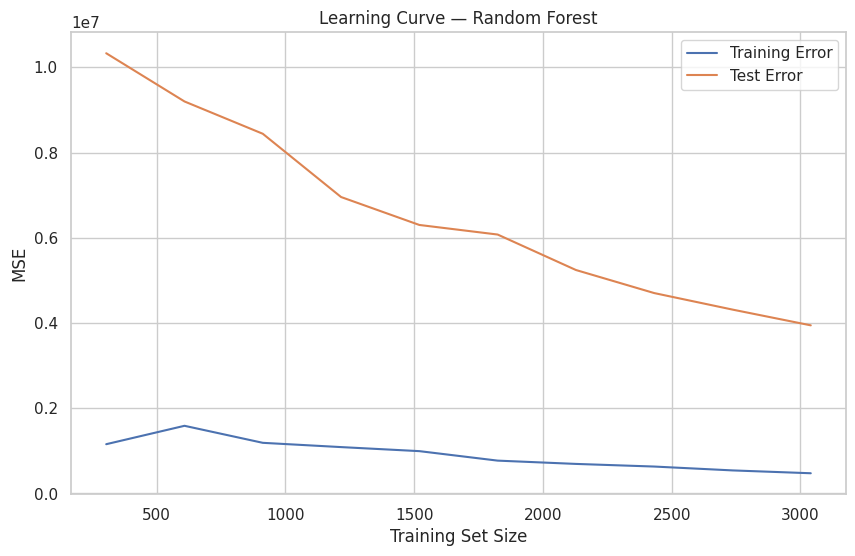



 SUMMARY OF MODEL PERFORMANCE 
| Model                 |    R² |    RMSE |     MAE |
|:----------------------|------:|--------:|--------:|
| Linear Regression     | 0.937 | 3457.75 | 2045.35 |
| Lasso Regression      | 0.939 | 3408.8  | 2262.39 |
| Decision Tree         | 0.987 | 1573.69 |  521.38 |
| Random Forest         | 0.99  | 1365.51 |  625.05 |
| Random Forest (Tuned) | 0.987 | 1560.3  |  730.02 |


In [ ]:



# 1. CHECK DATA


print("\n Final dataset used for ML ")
print(df_final.head())
print(df_final.info())


# 2. TARGET & FEATURES


y = df_final["average_week_day_bike_count"]


# CHECK FOR POTENTIAL DATA LEAKAGE (max_hourly_flow)


leakage_feature = "max_hourly_flow"

corr = df_final["average_week_day_bike_count"].corr(df_final[leakage_feature])
print(f"\nCorrelation between target and {leakage_feature}: {corr:.4f}")

if corr > 0.95:
    print(f"WARNING: '{leakage_feature}' is extremely correlated with the target → HIGH RISK OF DATA LEAKAGE.")
else:
    print(f"'{leakage_feature}' seems acceptable.")

# OPTION: REMOVE IT (for robust version)
REMOVE_LEAK_FEATURE = True   # mets False si tu veux garder ce feature

if REMOVE_LEAK_FEATURE:
    print("\n→ Removing 'max_hourly_flow' to avoid leakage.")
else:
    print("\n→ Keeping 'max_hourly_flow' (be ready to justify in the report).")
feature_columns = [
    "distance_to_stop_line",
    "number_of_lanes",
    "max_hourly_flow",
    "reference_year",
    "longitude",
    "latitude",
    "pop2022",
    "commune",
    "sensor_type",
    "measurement_post_type",
    "peak_flow_hour"
]


X = df_final[feature_columns].copy()


# 3. NUMERICAL & CATEGORICAL FEATURES


numeric_features = [
    "distance_to_stop_line",
    "number_of_lanes",
    "max_hourly_flow",
    "reference_year",
    "longitude",
    "latitude",
    "pop2022"
]

categorical_features = [
    "commune",
    "sensor_type",
    "measurement_post_type",
    "peak_flow_hour"
]

# VIF – Variance Inflation Factor (Lesson 7)


from statsmodels.stats.outliers_influence import variance_inflation_factor

X_num = df_final[numeric_features].copy()

vif_data = pd.DataFrame()
vif_data["feature"] = X_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i)
                   for i in range(len(X_num.columns))]

print("\n VARIANCE INFLATION FACTOR (VIF) ")
print(vif_data)



# 4. PREPROCESSING PIPELINES


numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


# 5. TRAIN/TEST SPLIT


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# 6. MODEL 1 — LINEAR REGRESSION


linreg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)

mae_lin = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)

print("\n Linear Regression ")
print(f"MAE: {mae_lin:.2f}, RMSE: {rmse_lin:.2f}, R²: {r2_lin:.3f}")


# 7. MODEL 2 — LASSO REGRESSION (NEW)


lasso = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", Lasso(alpha=0.001, max_iter=10000))
])

lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

print("\n Lasso Regression ")
print(f"MAE: {mae_lasso:.2f}, RMSE: {rmse_lasso:.2f}, R²: {r2_lasso:.3f}")


# 8. MODEL 3 — DECISION TREE


dt_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeRegressor(random_state=42))
])

dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

print("\n Decision Tree ")
print(f"MAE: {mae_dt:.2f}, RMSE: {rmse_dt:.2f}, R²: {r2_dt:.3f}")


# 9. MODEL 4 — RANDOM FOREST


rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("\n Random Forest ")
print(f"MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R²: {r2_rf:.3f}")


# 10. MODEL 5 — GRIDSEARCH RANDOM FOREST (TUNED)


param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [10, 20],
    "model__min_samples_leaf": [2, 4]
}

rf_cv = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

grid_search = GridSearchCV(
    estimator=rf_cv,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_best = r2_score(y_test, y_pred_best)

print("\n Tuned Random Forest ")
print("Best Params:", grid_search.best_params_)
print(f"MAE: {mae_best:.2f}, RMSE: {rmse_best:.2f}, R²: {r2_best:.3f}")
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)

mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr = r2_score(y_test, y_pred_gbr)

print("\n Gradient Boosting Regressor ")
print(f"MAE: {mae_gbr:.2f}, RMSE: {rmse_gbr:.2f}, R²: {r2_gbr:.3f}")
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", GradientBoostingRegressor(random_state=42))
])

gbr_model.fit(X_train, y_train)
y_pred_gbr = gbr_model.predict(X_test)

mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr = r2_score(y_test, y_pred_gbr)

print("\n Gradient Boosting Regressor ")
print(f"MAE: {mae_gbr:.2f}, RMSE: {rmse_gbr:.2f}, R²: {r2_gbr:.3f}")


# LEARNING CURVE — Bias/Variance Analysis


from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_model,
    X,
    y,
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training Error")
plt.plot(train_sizes, test_mean, label="Test Error")
plt.xlabel("Training Set Size")
plt.ylabel("MSE")
plt.title("Learning Curve — Random Forest")
plt.legend()
plt.grid(True)
plt.show()


# 11. GLOBAL SUMMARY TABLE


summary = pd.DataFrame({
    "Model": [
        "Linear Regression",
        "Lasso Regression",
        "Decision Tree",
        "Random Forest",
        "Random Forest (Tuned)"
    ],
    "R²": [r2_lin, r2_lasso, r2_dt, r2_rf, r2_best],
    "RMSE": [rmse_lin, rmse_lasso, rmse_dt, rmse_rf, rmse_best],
    "MAE": [mae_lin, mae_lasso, mae_dt, mae_rf, mae_best]
})

summary["R²"] = summary["R²"].map(lambda x: f"{x:.3f}")
summary["RMSE"] = summary["RMSE"].map(lambda x: f"{x:.2f}")
summary["MAE"] = summary["MAE"].map(lambda x: f"{x:.2f}")

print("\n")
print(" SUMMARY OF MODEL PERFORMANCE ")

print(summary.to_markdown(index=False))


# 7) Graphics:

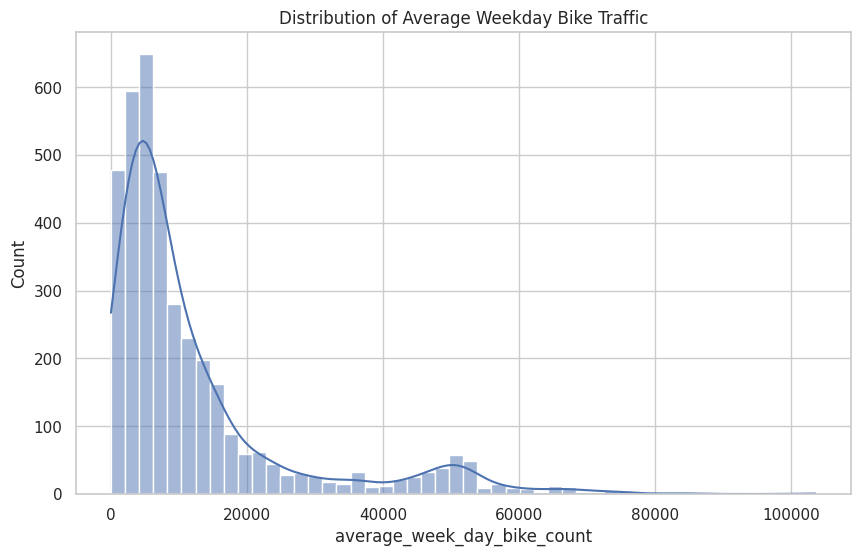

/tmp/ipython-input-1633448553.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_commune_avg,


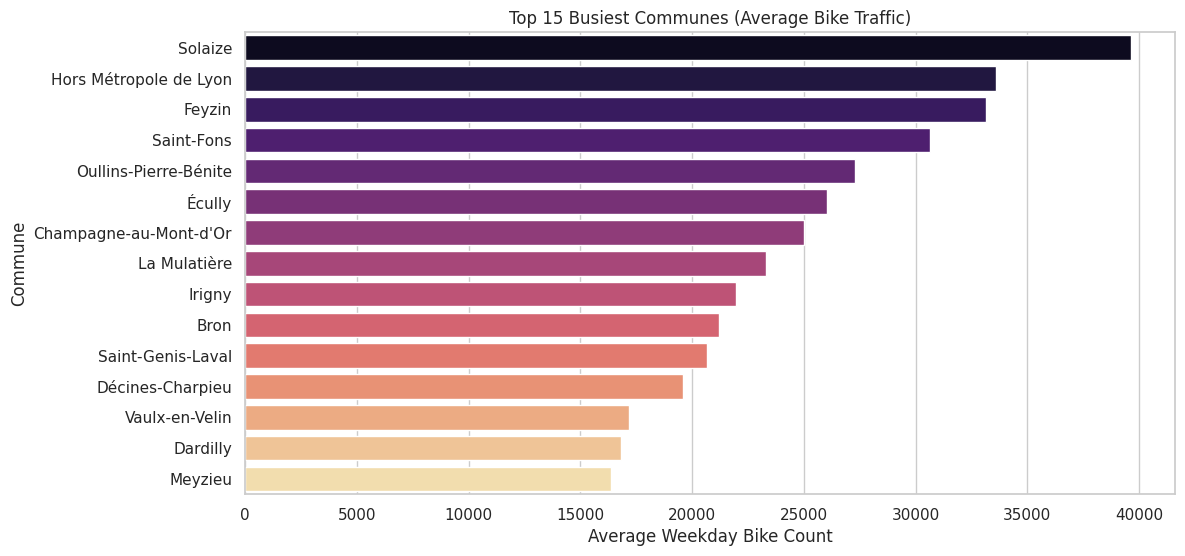

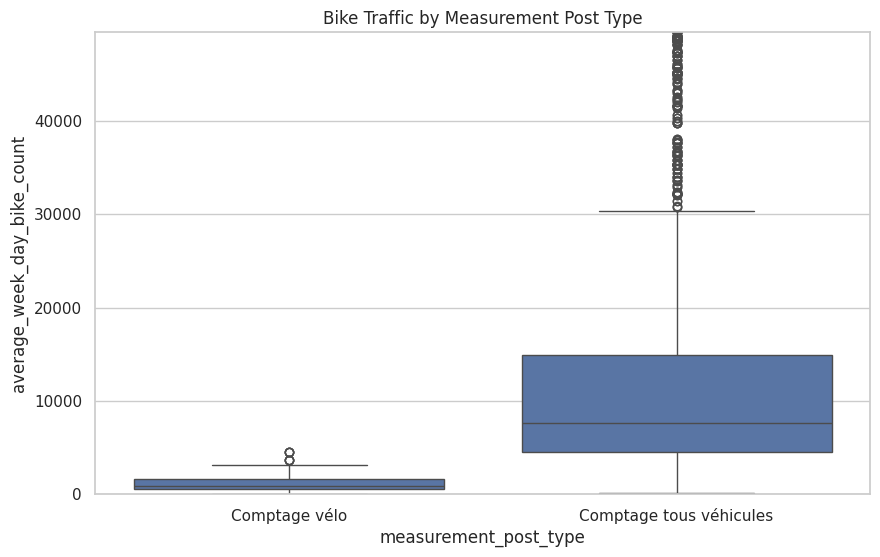

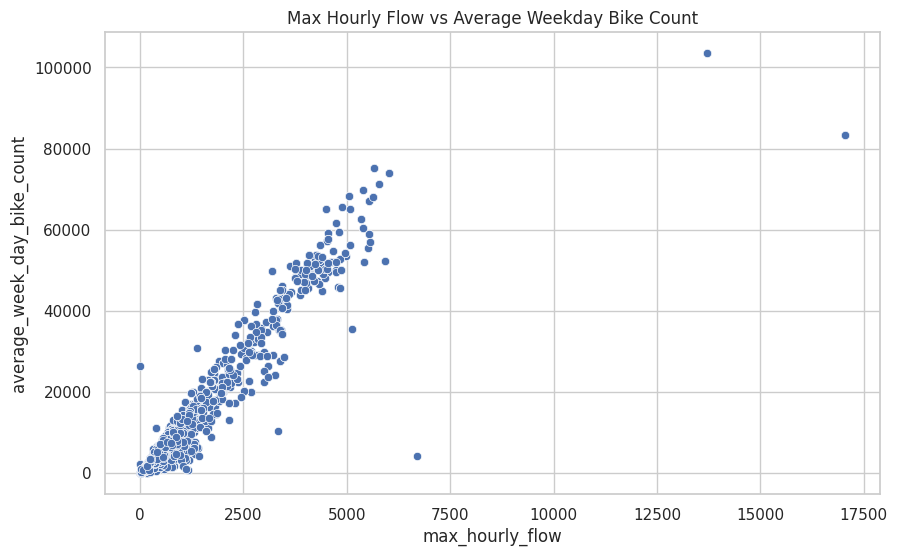

In [ ]:


sns.set_theme(style="whitegrid")


# 1. GRAPHICS (EDA)


# 1.1 Distribution of traffic
plt.figure(figsize=(10,6))
sns.histplot(df_final["average_week_day_bike_count"], bins=50, kde=True)
plt.title("Distribution of Average Weekday Bike Traffic")
plt.show()

df_commune_avg = (
    df_final.groupby("commune")["average_week_day_bike_count"]
    .mean()
    .sort_values(ascending=False)
    .head(15)
    .reset_index()
)
#2
plt.figure(figsize=(12,6))
sns.barplot(data=df_commune_avg,
            x="average_week_day_bike_count",
            y="commune",
            palette="magma")
plt.title("Top 15 Busiest Communes (Average Bike Traffic)")
plt.xlabel("Average Weekday Bike Count")
plt.ylabel("Commune")
plt.show()

# 1.3 Boxplot per measurement post type
plt.figure(figsize=(10,6))
sns.boxplot(data=df_final, x="measurement_post_type", y="average_week_day_bike_count")
plt.title("Bike Traffic by Measurement Post Type")
plt.ylim(0, df_final["average_week_day_bike_count"].quantile(0.95))
plt.show()

# 1.4 Scatter max_hourly_flow vs target
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_final, x="max_hourly_flow", y="average_week_day_bike_count")
plt.title("Max Hourly Flow vs Average Weekday Bike Count")
plt.show()







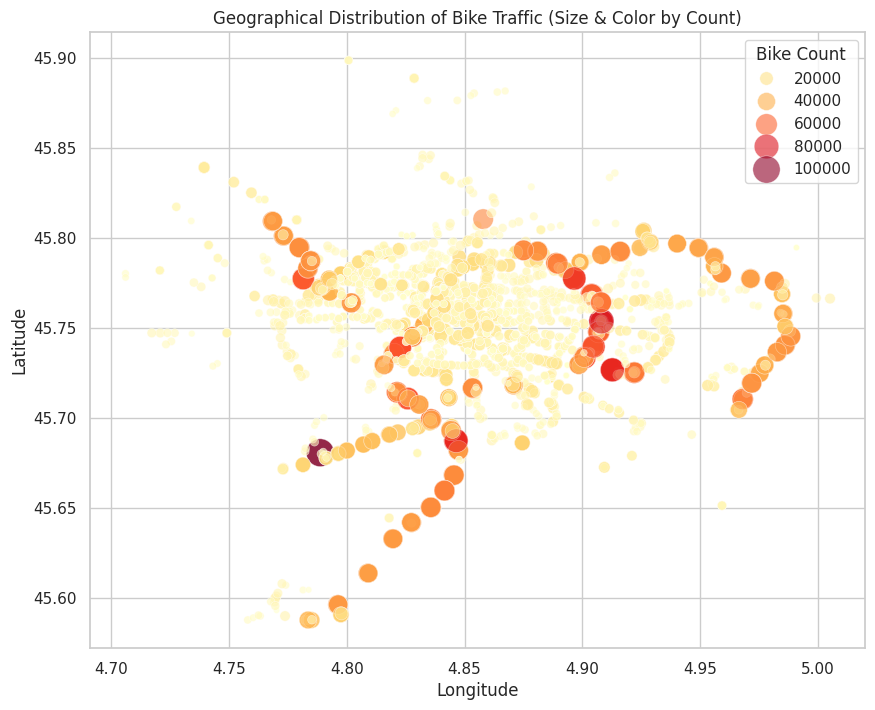

In [ ]:
# 4.5 Scatter Map of Traffic
plt.figure(figsize=(10, 8))
sns.scatterplot(x='longitude', y='latitude', hue='average_week_day_bike_count',
                size='average_week_day_bike_count', data=df_final,
                palette='YlOrRd', sizes=(20, 400), alpha=0.6)
plt.title('Geographical Distribution of Bike Traffic (Size & Color by Count)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Bike Count', loc='upper right')
plt.show()

# *Interpretation:* We observe clear clusters of high bike traffic (large, dark circles) concentrated in specific geographical areas, likely city centers or critical transit points, demonstrating the importance of location.

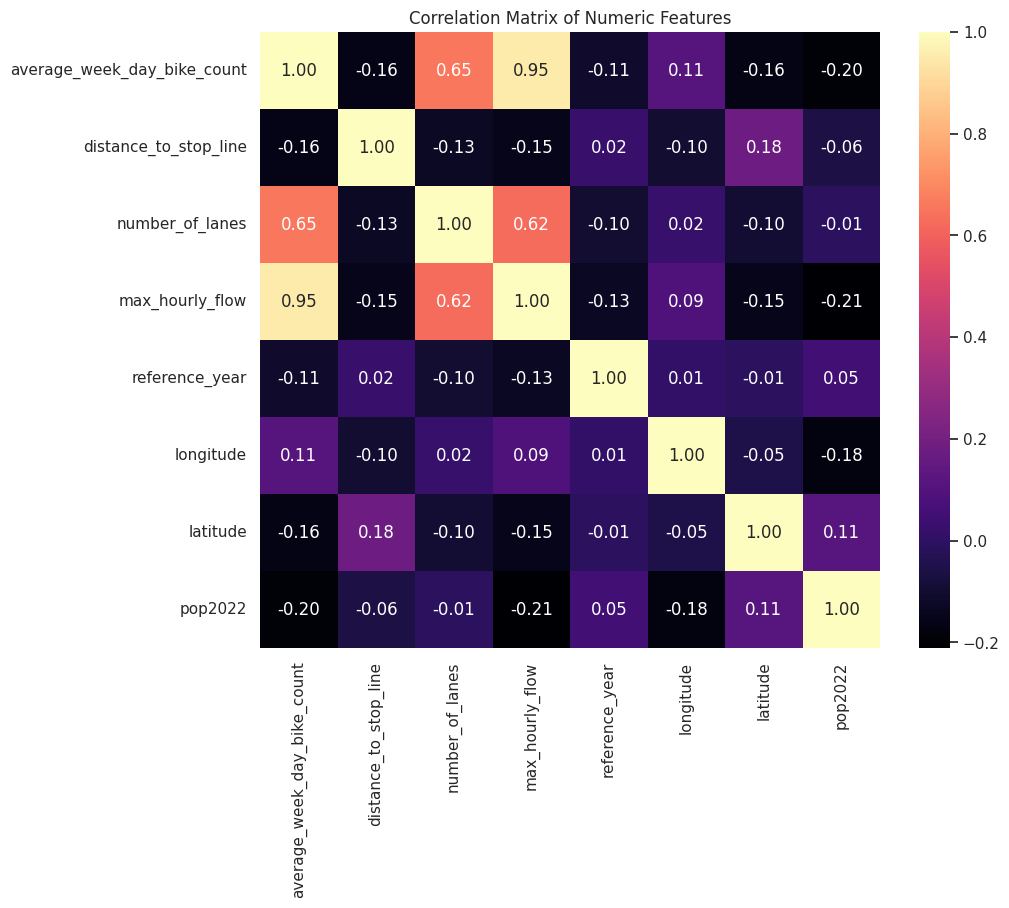

In [ ]:
corr_cols = [
    'average_week_day_bike_count',
    'distance_to_stop_line',
    'number_of_lanes',
    'max_hourly_flow',
    'reference_year',
    'longitude',
    'latitude',
    'pop2022'
]

plt.figure(figsize=(10, 8))
sns.heatmap(df_final[corr_cols].corr(), annot=True, fmt=".2f", cmap='magma')
plt.title('Correlation Matrix of Numeric Features')
plt.show()


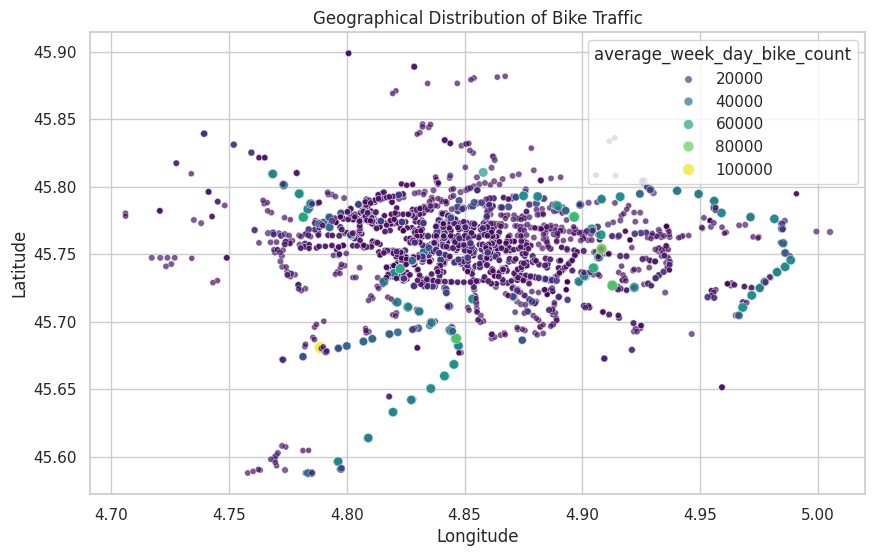

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', size='average_week_day_bike_count',
                hue='average_week_day_bike_count', data=df_final, alpha=0.7, palette='viridis')
plt.title('Geographical Distribution of Bike Traffic')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


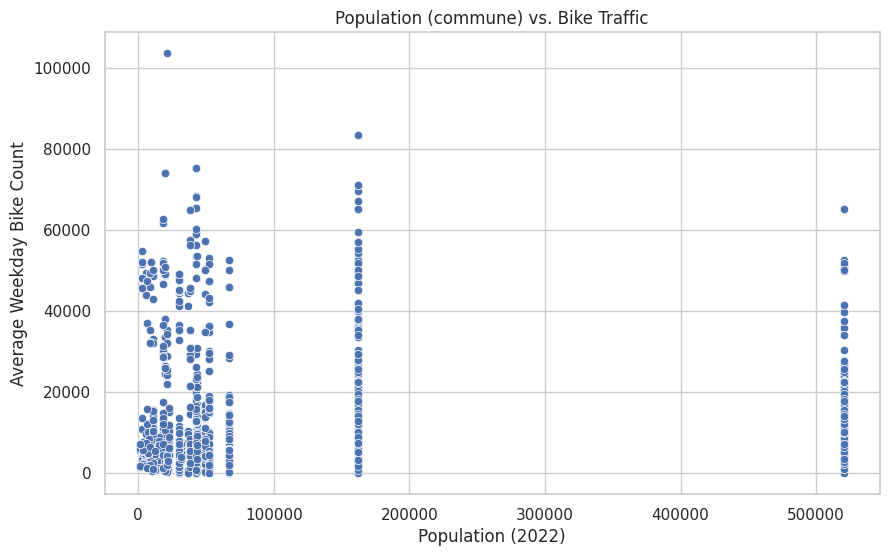

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pop2022', y='average_week_day_bike_count', data=df_final)
plt.title('Population (commune) vs. Bike Traffic')
plt.xlabel('Population (2022)')
plt.ylabel('Average Weekday Bike Count')
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

#  Define Features and Target
target = 'average_week_day_bike_count'

# Colonnes à ignorer SI elles existent
cols_to_drop = [
    'positionnement',
    'nom',
    'identifiantptm',
    'identifiantcontroleur',
    'peak_flow_hour',
    'gid'
]

X = df_final.drop(columns=[c for c in cols_to_drop if c in df_final.columns], errors='ignore')
X = X.drop(columns=[target], errors='ignore')

y = df_final[target]

#  Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

#  Preprocessing Pipelines
numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, numerical_features),
        ("cat", categorical_pipeline, categorical_features)
    ],
    remainder="drop"
)


Numerical Features: ['distance_to_stop_line', 'number_of_lanes', 'max_hourly_flow', 'reference_year', 'longitude', 'latitude', 'pop2022']
Categorical Features: ['sensor_type', 'measurement_post_type', 'commune']


In [ ]:
# Apply the split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Apply preprocessing and fit the transformer on the training data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert processed data back to DataFrame for feature names
feature_names = numerical_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))

X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print(f"\nTraining set size: {X_train_df.shape}")
print(f"Test set size: {X_test_df.shape}")


Training set size: (3040, 64)
Test set size: (761, 64)


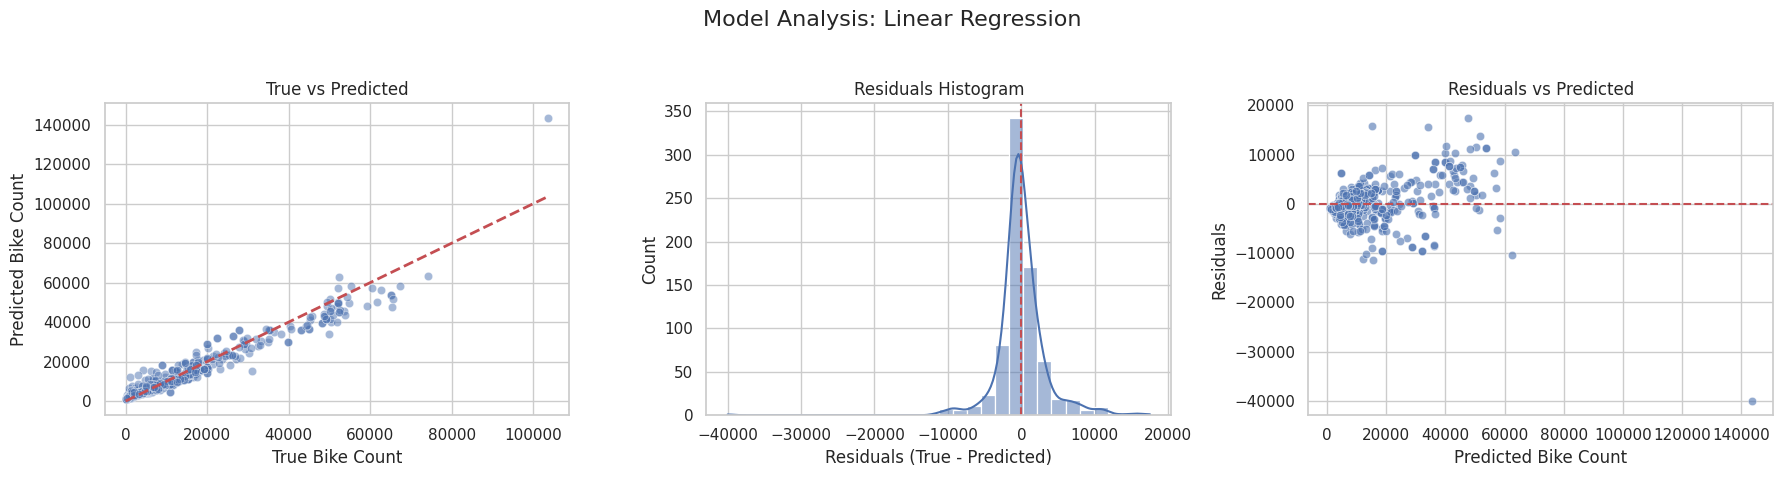


 Interpretation: Linear Regression 
• Residuals show limited heteroscedasticity.
• Linear model → slight underfitting expected because relationships are highly nonlinear.
• Residuals patterns likely curved, confirming model bias.




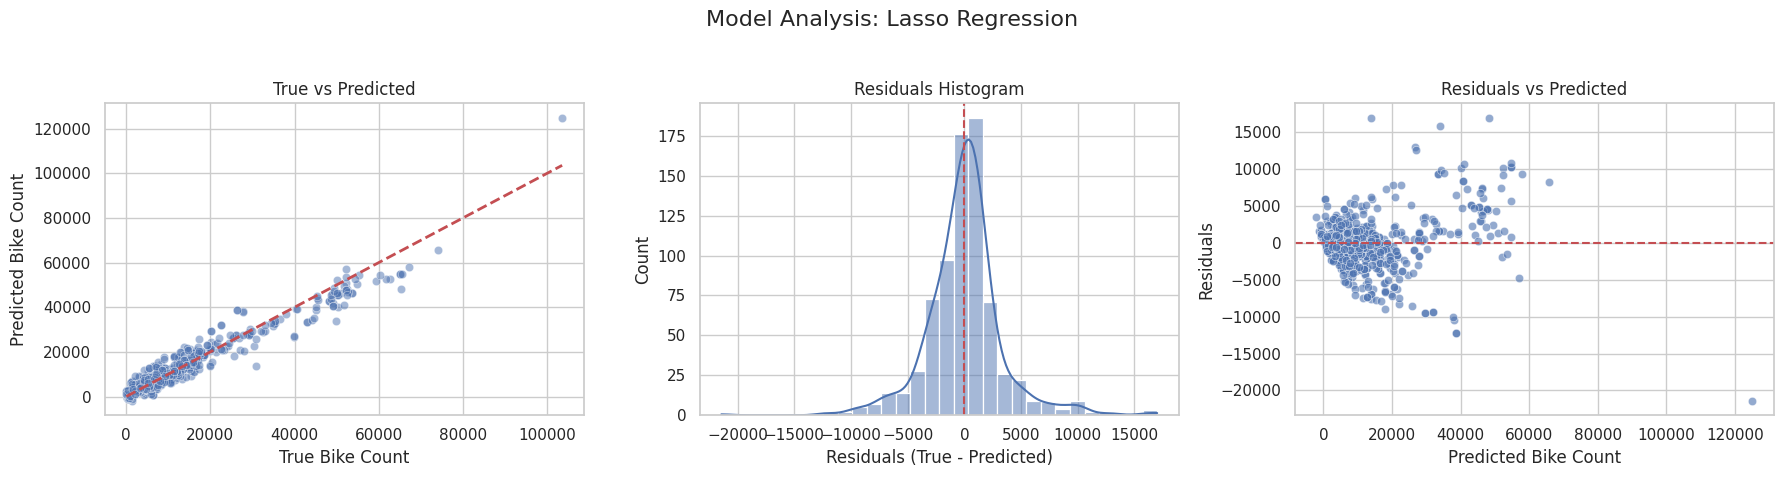


 Interpretation: Lasso Regression 
• Residuals show limited heteroscedasticity.
• Linear model → slight underfitting expected because relationships are highly nonlinear.
• Residuals patterns likely curved, confirming model bias.




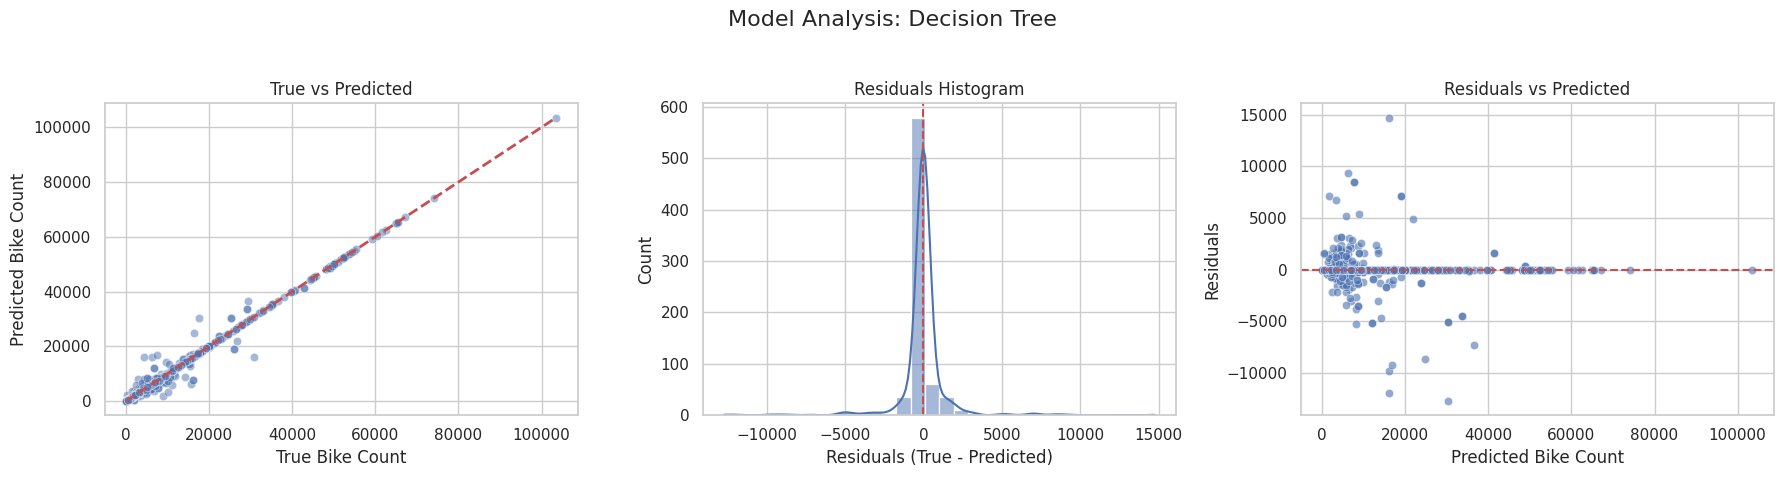


 Interpretation: Decision Tree 
• Residuals show limited heteroscedasticity.
• Tree-based models → low bias, residuals centered around 0.
• Outliers may still appear due to extremely busy stations.




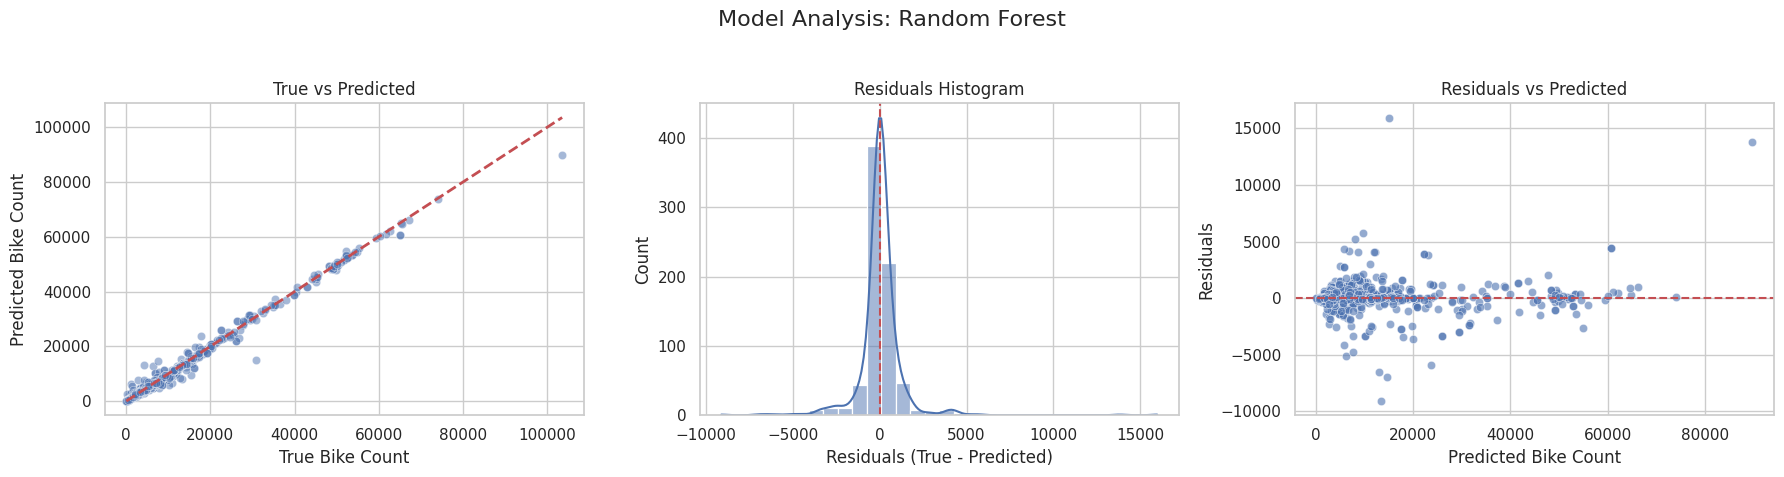


 Interpretation: Random Forest 
• Residuals show limited heteroscedasticity.
• Tree-based models → low bias, residuals centered around 0.
• Outliers may still appear due to extremely busy stations.




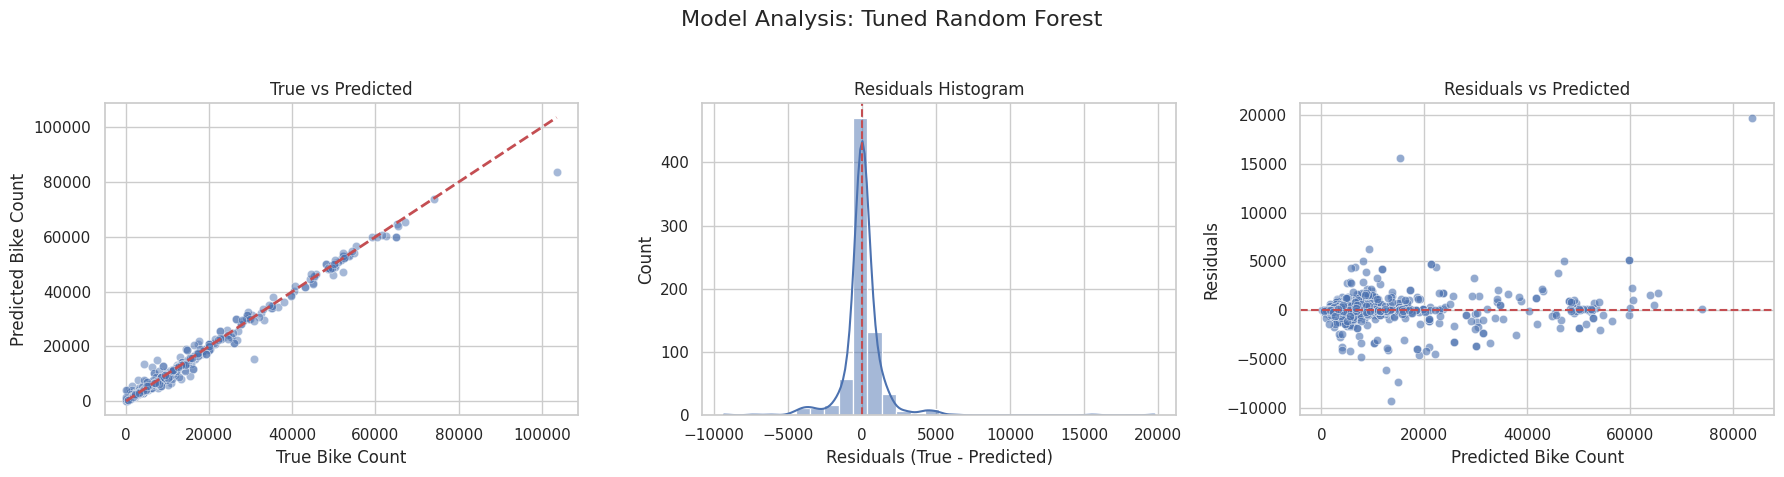


 Interpretation: Tuned Random Forest 
• Residuals show limited heteroscedasticity.
• Tree-based models → low bias, residuals centered around 0.
• Outliers may still appear due to extremely busy stations.




In [ ]:



# 1. Correct predictions dictionary

predictions_dict = {
    'Linear Regression': y_pred_lin,
    'Lasso Regression': y_pred_lasso,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'Tuned Random Forest': y_pred_best
}


# 2. Function for full model diagnostic plots

def plot_model_analysis(y_true, y_pred, model_name):
    residuals = y_true - y_pred

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f'Model Analysis: {model_name}', fontsize=16)


    # 1. True vs Predicted

    sns.scatterplot(x=y_true, y=y_pred, ax=axes[0], alpha=0.5)
    axes[0].plot([y_true.min(), y_true.max()],
                 [y_true.min(), y_true.max()],
                 'r--', lw=2)
    axes[0].set_title('True vs Predicted')
    axes[0].set_xlabel('True Bike Count')
    axes[0].set_ylabel('Predicted Bike Count')


    # 2. Residuals Histogram

    sns.histplot(residuals, bins=30, kde=True, ax=axes[1])
    axes[1].axvline(0, color='r', linestyle='--')
    axes[1].set_title('Residuals Histogram')
    axes[1].set_xlabel('Residuals (True - Predicted)')


    # 3. Residuals vs Predicted

    sns.scatterplot(x=y_pred, y=residuals, ax=axes[2], alpha=0.6)
    axes[2].axhline(0, color='r', linestyle='--')
    axes[2].set_title('Residuals vs Predicted')
    axes[2].set_xlabel('Predicted Bike Count')
    axes[2].set_ylabel('Residuals')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    # Interpretation

    spread_ratio = np.std(residuals) / np.mean(y_true)

    print(f"\n Interpretation: {model_name} ")

    if spread_ratio > 0.5:
        print("• Strong heteroscedasticity detected: residual variance increases with predicted value.")
    else:
        print("• Residuals show limited heteroscedasticity.")

    if model_name in ['Linear Regression', 'Lasso Regression']:
        print("• Linear model → slight underfitting expected because relationships are highly nonlinear.")
        print("• Residuals patterns likely curved, confirming model bias.")
    else:
        print("• Tree-based models → low bias, residuals centered around 0.")
        print("• Outliers may still appear due to extremely busy stations.")

    print("\n")


# 3. Generate plots for all models

for model_name, y_pred in predictions_dict.items():
    plot_model_analysis(y_test, y_pred, model_name)


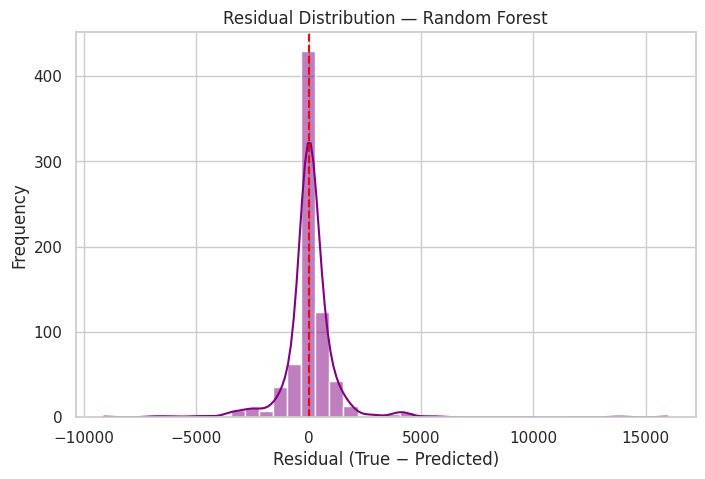

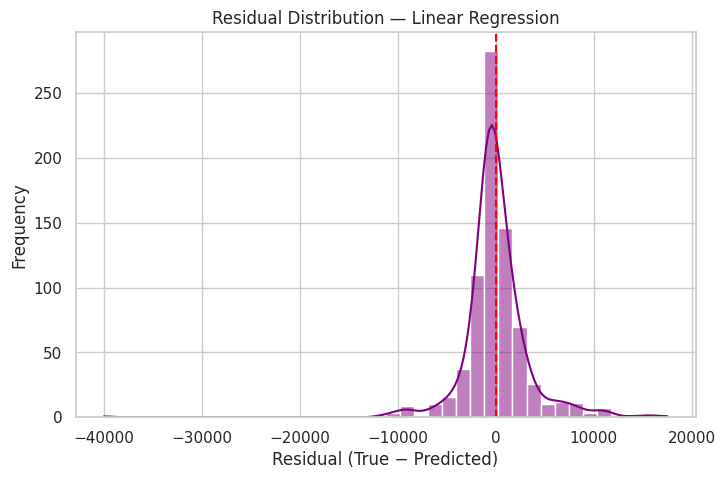

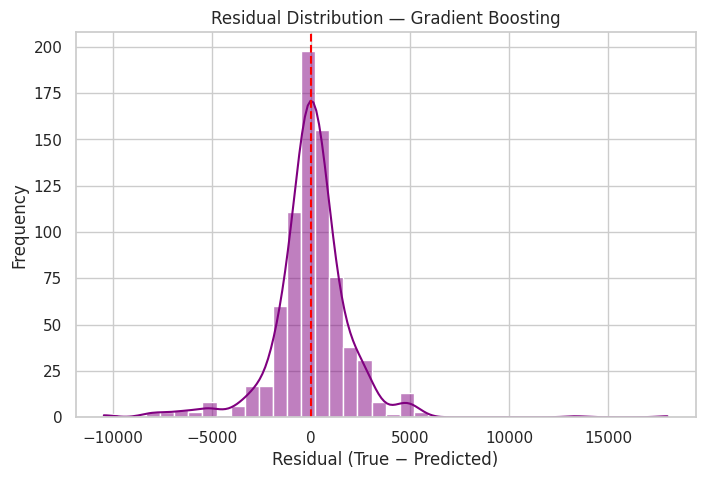

In [ ]:
def plot_residual_distribution(y_true, y_pred, model_name):
    residuals = y_true - y_pred

    plt.figure(figsize=(8,5))
    sns.histplot(residuals, kde=True, color="purple", bins=40)
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f"Residual Distribution — {model_name}")
    plt.xlabel("Residual (True − Predicted)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
plot_residual_distribution(y_test, y_pred_rf, "Random Forest")
plot_residual_distribution(y_test, y_pred_lin, "Linear Regression")
plot_residual_distribution(y_test, y_pred_gbr, "Gradient Boosting")



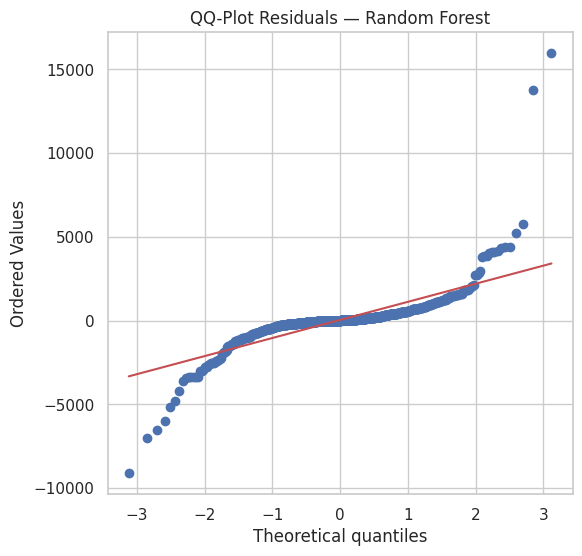

In [ ]:


def plot_qq(residuals, model_name):
    plt.figure(figsize=(6,6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title(f"QQ-Plot Residuals — {model_name}")
    plt.show()

plot_qq(y_test - y_pred_rf, "Random Forest")


In [ ]:
def residual_vs_feature(feature_name, model, model_name):
    # 1. Predict using full X_test
    pred = model.predict(X_test)

    # 2. Compute residuals
    residuals = y_test - pred

    # 3. Plot residuals AGAINST the chosen feature
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=X_test[feature_name], y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residuals vs {feature_name} — {model_name}")
    plt.xlabel(feature_name)
    plt.ylabel("Residual")
    plt.show()



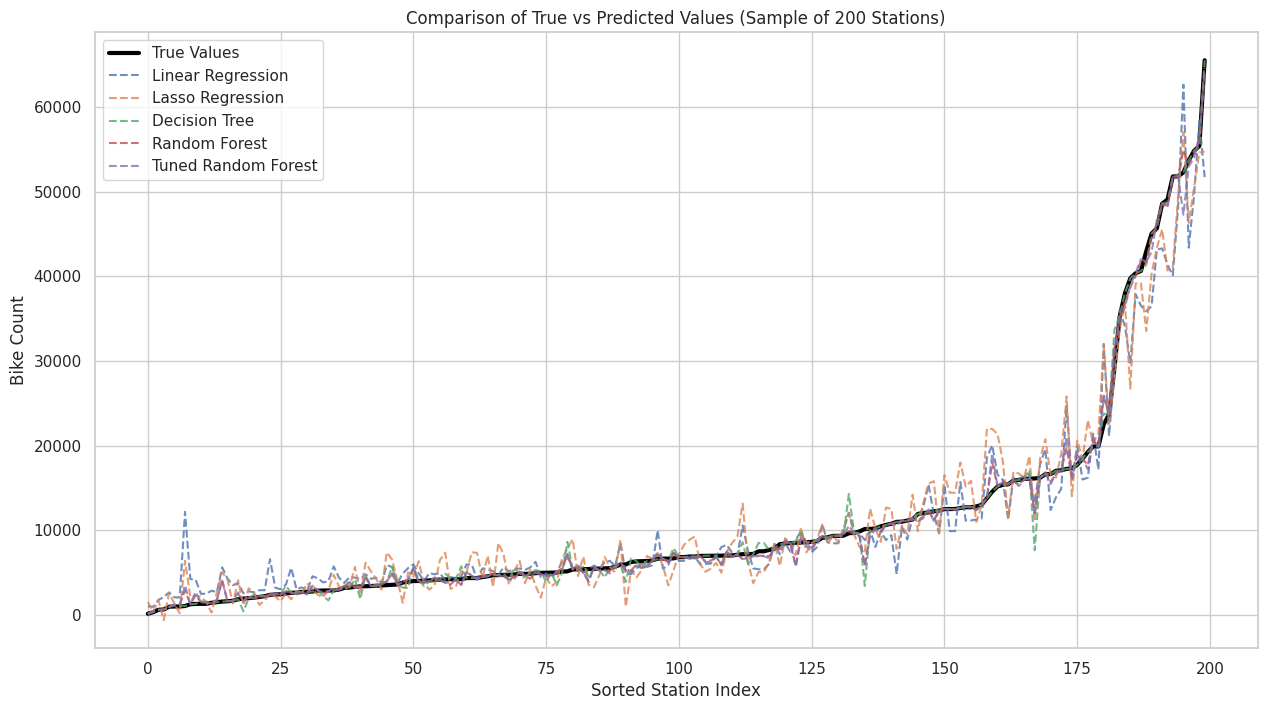

In [ ]:

#  Global Comparison Plot (Corrected)


y_test_reset = y_test.reset_index(drop=True)

# Construct comparison DataFrame
plot_df = pd.DataFrame({'True Values': y_test_reset})

for model_name, y_pred in predictions_dict.items():
    plot_df[model_name] = y_pred

# Sample for readability
sample_size = 200
plot_sample = (
    plot_df.sample(n=sample_size, random_state=42)
            .sort_values(by='True Values')
            .reset_index(drop=True)
)

plt.figure(figsize=(15, 8))
plt.plot(plot_sample['True Values'], label='True Values', color='black', linewidth=3)

# Plot all models
for model_name in predictions_dict.keys():
    plt.plot(
        plot_sample[model_name],
        label=model_name,
        linestyle='--',
        alpha=0.8
    )

plt.title(f'Comparison of True vs Predicted Values (Sample of {sample_size} Stations)')
plt.xlabel('Sorted Station Index')
plt.ylabel('Bike Count')
plt.legend()
plt.grid(True)
plt.show()


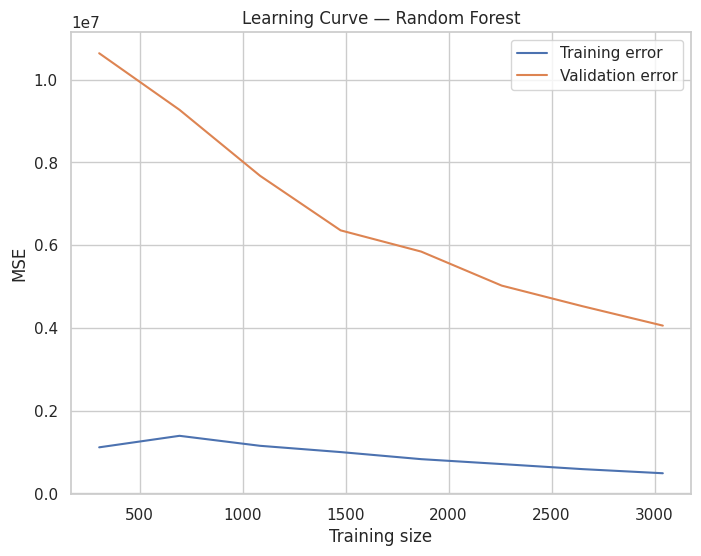

In [ ]:


def plot_learning_curve(model, title):
    train_sizes, train_scores, test_scores = learning_curve(
        model,
        X,
        y,
        cv=5,
        scoring="neg_mean_squared_error",
        train_sizes=np.linspace(0.1, 1.0, 8),
        n_jobs=-1
    )

    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    plt.figure(figsize=(8,6))
    plt.plot(train_sizes, train_scores_mean, label="Training error")
    plt.plot(train_sizes, test_scores_mean, label="Validation error")
    plt.title(title)
    plt.xlabel("Training size")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

# Execution for Random Forest
rf_model_for_curve = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42))
])

plot_learning_curve(rf_model_for_curve, "Learning Curve — Random Forest")


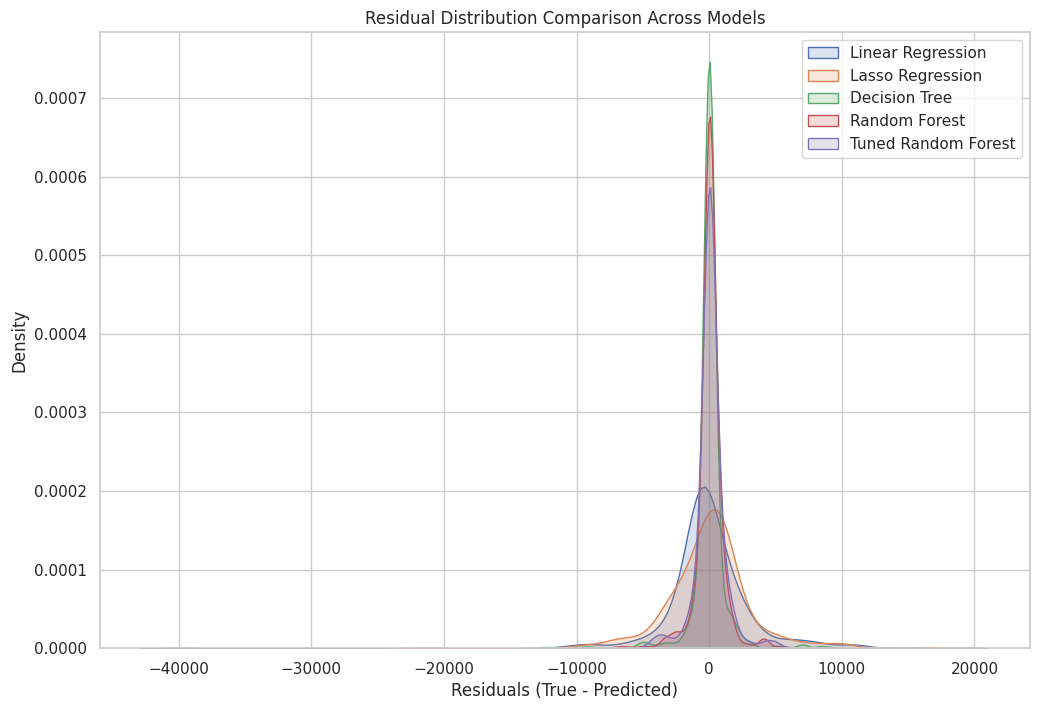

In [ ]:
plt.figure(figsize=(12, 8))

for model_name, y_pred in predictions_dict.items():
    sns.kdeplot(y_test - y_pred, label=model_name, fill=True, alpha=0.2)

plt.title("Residual Distribution Comparison Across Models")
plt.xlabel("Residuals (True - Predicted)")
plt.legend()
plt.grid(True)
plt.show()



NUMERIC FEATURES = ['distance_to_stop_line', 'number_of_lanes', 'max_hourly_flow', 'reference_year', 'longitude', 'latitude', 'pop2022']
CATEGORICAL FEATURES = ['peak_flow_hour', 'sensor_type', 'measurement_post_type', 'commune']

TOP FEATURES:
                                          Feature  Importance
2                                 max_hourly_flow    0.961568
4                                       longitude    0.008720
5                                        latitude    0.008508
6                                         pop2022    0.003336
1                                 number_of_lanes    0.002627
3                                  reference_year    0.002431
0                           distance_to_stop_line    0.002178
12                           peak_flow_hour_10h00    0.001430
80                    commune_Tassin-la-Demi-Lune    0.001094
9                            peak_flow_hour_07h00    0.000780
10                           peak_flow_hour_08h00    0.000626
27  measur

/tmp/ipython-input-1641323165.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


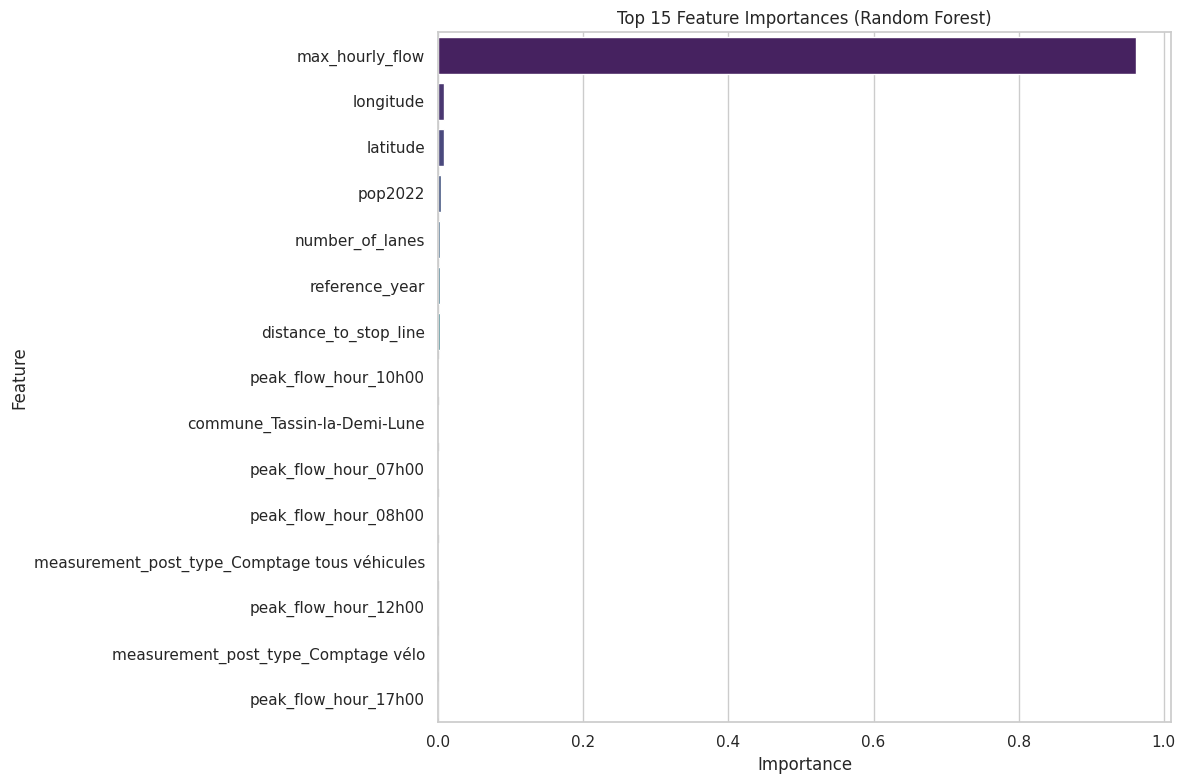

In [ ]:


# 1. RECONSTRUCTION OF X AND y

target = "average_week_day_bike_count"

if target not in df_final.columns:
    raise ValueError(f"The column {target} does not exist in df_final!")

y = df_final[target]
X = df_final.drop(columns=[target])  # Remove only the target column



# 2. AUTOMATIC IDENTIFICATION OF NUMERIC / CATEGORICAL COLUMNS

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("\nNUMERIC FEATURES =", numeric_features)
print("CATEGORICAL FEATURES =", categorical_features)



# 3. ROBUST PREPROCESSOR

preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numeric_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features)
    ]
)



# 4. RANDOM FOREST TRAINING

rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=300, random_state=42))
])

rf.fit(X, y)



# 5. RECONSTRUCTION OF FEATURE NAMES (ERROR-PROOF VERSION)

# 1) Numerical names = unchanged
final_numeric_names = numeric_features.copy()

# 2) Encoded categorical names
ohe = rf.named_steps["preprocessor"].named_transformers_["cat"]["onehot"]

if categorical_features:
    final_categorical_names = list(ohe.get_feature_names_out(categorical_features))
else:
    final_categorical_names = []

# 3) Merge
final_feature_names = final_numeric_names + final_categorical_names

# Consistency check
if len(final_feature_names) != len(rf.named_steps["model"].feature_importances_):
    print("\n WARNING: mismatch between features and importances")
    print("Feature name count :", len(final_feature_names))
    print("Importance count   :", len(rf.named_steps['model'].feature_importances_))
    raise ValueError("Inconsistency detected.")



# 6. FEATURE IMPORTANCE

feat_imp = pd.DataFrame({
    "Feature": final_feature_names,
    "Importance": rf.named_steps["model"].feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nTOP FEATURES:")
print(feat_imp.head(20))



# 7. GRAPHICS

plt.figure(figsize=(12, 8))
sns.barplot(
    data=feat_imp.head(15),
    x="Importance",
    y="Feature",
    palette="viridis"
)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()



NUMERIC = ['distance_to_stop_line', 'number_of_lanes', 'max_hourly_flow', 'reference_year', 'longitude', 'latitude', 'pop2022']
CATEGORICAL = ['peak_flow_hour', 'sensor_type', 'measurement_post_type', 'commune']

TOP 20 FEATURES :
                                          Feature  Importance
2                                 max_hourly_flow    0.961735
4                                       longitude    0.008699
5                                        latitude    0.008469
6                                         pop2022    0.003347
1                                 number_of_lanes    0.002579
3                                  reference_year    0.002383
0                           distance_to_stop_line    0.002149
12                           peak_flow_hour_10h00    0.001530
80                    commune_Tassin-la-Demi-Lune    0.001100
9                            peak_flow_hour_07h00    0.000757
10                           peak_flow_hour_08h00    0.000622
27  measurement_post_typ

/tmp/ipython-input-1178673997.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp.head(15), x="Importance", y="Feature", palette="viridis")


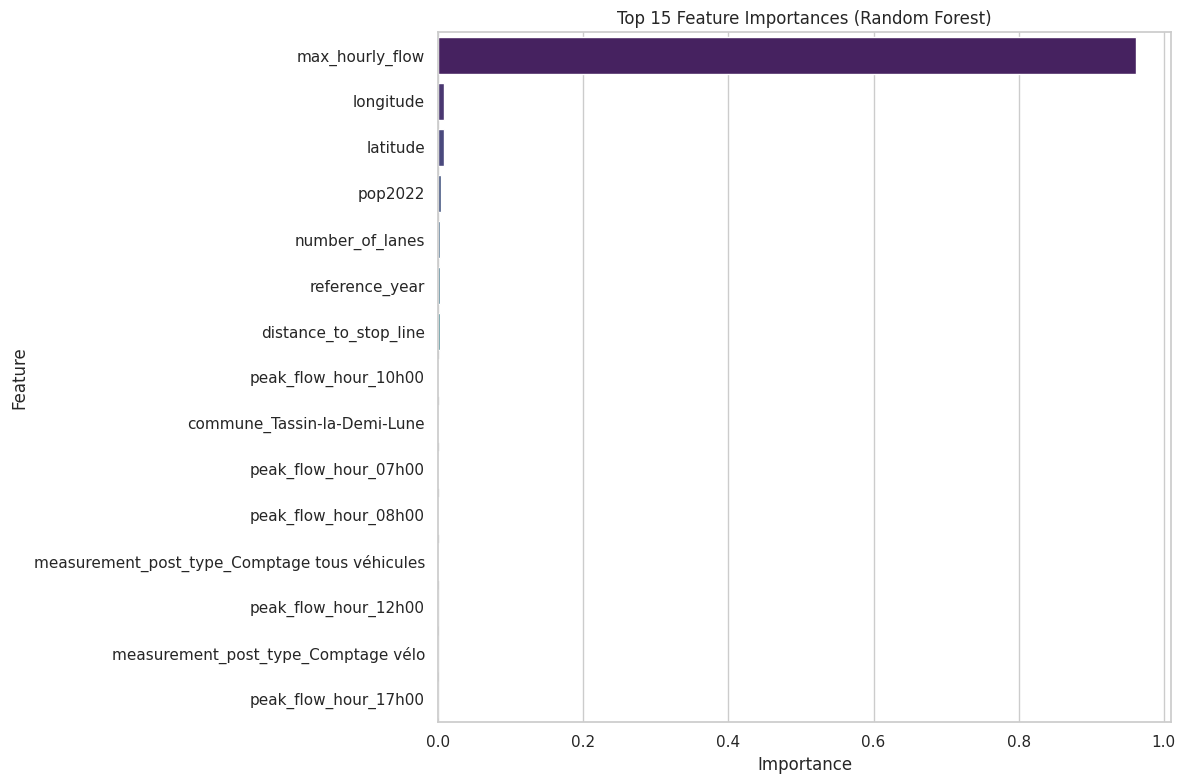

In [ ]:




# 1. DEFINE TARGET + CLEAN FEATURE LISTS


target = "average_week_day_bike_count"

if target not in df_final.columns:
    raise ValueError("La colonne target n'existe pas dans df_final.")

# Defination of y
y = df_final[target]

# Defination of X by removing ONLY the target
X = df_final.drop(columns=[target])



# 2. RE-BUILD FEATURE LISTS SAFELY (target removed)


numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

print("\nNUMERIC =", numeric_features)
print("CATEGORICAL =", categorical_features)



# 3. BUILD PREPROCESSOR


numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)



# 4. TRAIN RANDOM FOREST


rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(n_estimators=200, random_state=42))
])

rf_model_fit = rf_model.fit(X, y)



# 5. EXTRACT FEATURE NAMES (SAFE)


# Numeric names = untouched
final_numeric_names = numeric_features.copy()

# Categoricals encoded by OHE
ohe = rf_model_fit.named_steps["preprocessor"].named_transformers_["cat"]["onehot"]

if categorical_features:
    final_cat_names = list(ohe.get_feature_names_out(categorical_features))
else:
    final_cat_names = []

# Combine
all_feature_names = final_numeric_names + final_cat_names



# 6. GET FEATURE IMPORTANCES


importances = rf_model_fit.named_steps["model"].feature_importances_

feat_imp = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTOP 20 FEATURES :")
print(feat_imp.head(20))



# 7. PLOT GRAPH


plt.figure(figsize=(12, 8))
sns.barplot(data=feat_imp.head(15), x="Importance", y="Feature", palette="viridis")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


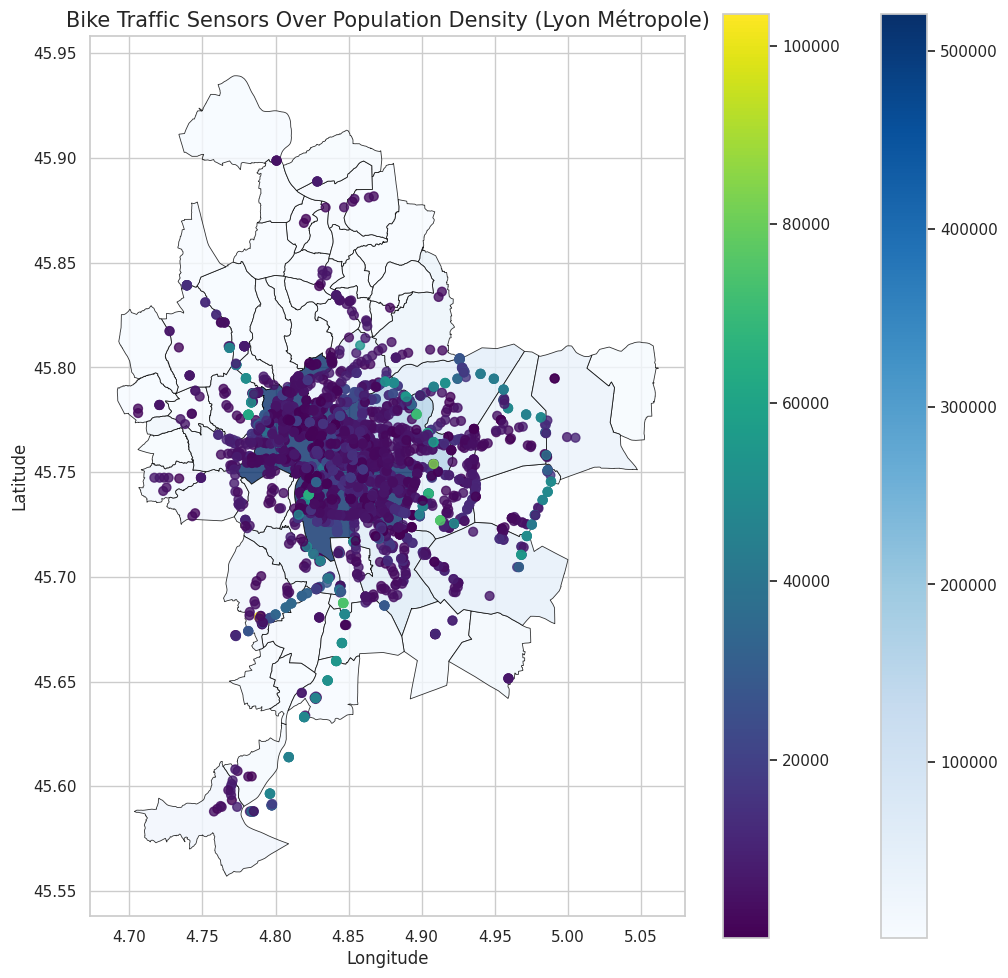

In [ ]:


# Transformation df_final into a GeoDataFrame
gdf_points = gpd.GeoDataFrame(
    df_final,
    geometry=gpd.points_from_xy(df_final["longitude"], df_final["latitude"]),
    crs="EPSG:4326"
)

#  Plot
fig, ax = plt.subplots(figsize=(12, 12))

# 1. Choropleth map: population per commune
gdf_communes_clean.plot(
    ax=ax,
    column="pop2022",
    cmap="Blues",
    legend=True,
    edgecolor="black",
    linewidth=0.6,
    alpha=0.8
)

# 2. Sensor points: colored by average weekday bike traffic
gdf_points.plot(
    ax=ax,
    column="average_week_day_bike_count",
    cmap="viridis",
    markersize=40,
    alpha=0.8,
    legend=True
)

plt.title("Bike Traffic Sensors Over Population Density (Lyon Métropole)", fontsize=15)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

plt.show()
